In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from lmfit import Model
import datetime


In [ ]:
# load data
file = 'C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/Raw_Images/RAW_Stacks/Intensity_Ratio/ratio_data.csv'
data = pd.read_csv(file, decimal=',')
print(data)


In [18]:
# Group the data by Air Saturation and calculate the mean ratio for each air saturation value
grouped_data = data.groupby('Air Saturation').mean().round(4)
print(grouped_data)

# Get the R0 value: Intensity Ratio at Air Saturation = 0%
R0 = data.iloc[0, 1]
print('this is R0',R0)

# Normalize the data by R0/R
grouped_data['Intensity Ratio'] = grouped_data['Intensity Ratio'] / R0 
print(grouped_data)


                Intensity Ratio     Std
Air Saturation                         
0                        1.2056  0.0014
2                        1.2037  0.0016
10                       1.2035  0.0014
20                       1.2110  0.0026
40                       1.2073  0.0017
50                       1.2104  0.0023
75                       1.2120  0.0027
80                       1.2058  0.0016
100                      1.2096  0.0021
this is R0 1.2054
                Intensity Ratio     Std
Air Saturation                         
0                      1.000166  0.0014
2                      0.998590  0.0016
10                     0.998424  0.0014
20                     1.004646  0.0026
40                     1.001576  0.0017
50                     1.004148  0.0023
75                     1.005475  0.0027
80                     1.000332  0.0016
100                    1.003484  0.0021


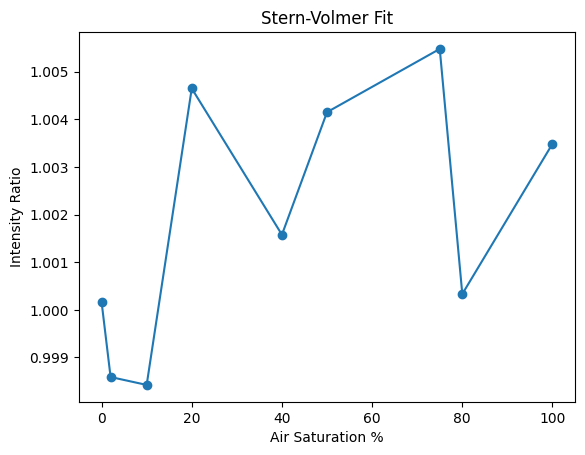

In [17]:
# Create a plot
plt.plot(grouped_data.index, grouped_data['Intensity Ratio'], 'o-')

# Set the x-axis and y-axis labels
plt.title('Stern-Volmer Fit')
plt.xlabel('Air Saturation %')
plt.ylabel('Intensity Ratio')
plt.show()

In [19]:
# define simplified Stern-Volmer function
def _sternvolmer_simple(x, f, k):
    """
    fitting function according to the common two site model. In general, x represents the pO2 or pCO2 content, whereas
    m, k and f are the common fitting parameters
    :param x:   list
    :param k:   np.float
    :param f:   np.float
    :return:
    """
    # R0/R
    int_ratio = 1 / (f / (1. + k*x) + (1.-f))
    return int_ratio

# make your function a model to be used by lmfit
simple_sv = Model(_sternvolmer_simple)

In [20]:
# set initial parameter
params_sens = simple_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

# use R0/R data for fit and re-calculate i afterwards
# full concentration range
ytofit_sens = grouped_data['Intensity Ratio'].to_numpy()
xtofit_sens = grouped_data.index.to_numpy() 
result = simple_sv.fit(ytofit_sens, params_sens, x=xtofit_sens, nan_policy='omit')

[[Model]]
    Model(_sternvolmer_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 9
    # variables        = 1
    chi-square         = 3.4813e-05
    reduced chi-square = 4.3516e-06
    Akaike info crit   = -110.164701
    Bayesian info crit = -109.967477
    R-squared          = 0.38375334
[[Variables]]
    f:  0.00457189 +/- 0.00130372 (28.52%) (init = 0.004571893)
    k:  0.03247093 (fixed)


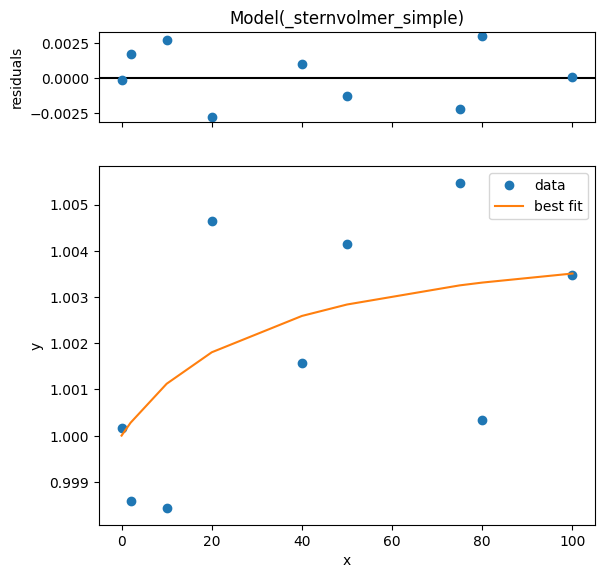

In [26]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simple_sv.fit(ytofit_sens, params_sens2, x=xtofit_sens, nan_policy='omit')

df_bestFit_preSens_norm = pd.DataFrame(1 / result2.best_fit, index=xtofit_sens)
df_bestFit_preSens = pd.DataFrame(grouped_data.loc[0, 'Intensity Ratio'] / result2.best_fit, index=xtofit_sens)
result2.best_values
fit_report = result2.fit_report()
print(fit_report)
result2.plot()
plt.show()



In [32]:
# SAVE THE RESULT
# best fit for parameter done... save report
import datetime

now = datetime.datetime.now()
time_now = now.strftime('%Y%m%d-%H%M%S')

# save fit report to a file
with open('C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/Raw_Images/RAW_Stacks/Intensity_Ratio/' + time_now + '_fit_result.txt', 'w') as fh:
    fh.write(fit_report)
